<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: 4.0 Model Testing

> Authors: Pius Yee, Conrad Aw, Eugene Matthew Cheong
---

## Table of Contents ##

### [1.0 Data Collection](./1.0%20Web%20Scraping.ipynb) ###

[1.1 Import Packages](./1.0%20Web%20Scraping.ipynb)

[1.2 Webscraping](./1.0%20Web%20Scraping.ipynb)

[1.3 Selection of subreddits](./1.0%20Web%20Scraping.ipynb)

[1.4 Code for text scraping](./1.0%20Web%20Scraping.ipynb)

### [2.0 Data Cleaning, Preprocessing and EDA](./2.0%20Data%20Cleaning%20&%20Preprocessing.ipynb)

[2.1 Import CSV file](./2.0%20Data%20Cleaning%20&%20Preprocessing.ipynb)

[2.2 Data cleaning](./2.0%20Data%20Cleaning%20&%20Preprocessing.ipynb)

[2.3 Preprocessing](./2.0%20Data%20Cleaning%20&%20Preprocessing.ipynb)

[2.4 Exploratory Data Analysis (EDA)](./2.0%20Data%20Cleaning%20&%20Preprocessing.ipynb)

### [3. Modelling, Evaluation and Tuning](./3.0%20Modelling.ipynb)

[3.1 Import CSV file](./3.0%20Modelling.ipynb)

[3.2 Splitting of train/test data](./3.0%20Modelling.ipynb)

[3.3 Modelling](./3.0%20Modelling.ipynb)

[3.4 Model Selection](./3.0%20Modelling.ipynb)

[3.5 AUC-ROC](./3.0%20Modelling.ipynb)

[3.6 Save it as Pickle](./3.0%20Modelling.ipynb)

[3.7 Recommendations](./3.0%20Modelling.ipynb)

[3.8 Conclusion](./3.0%20Modelling.ipynb)

### 4. Model Testing

[4.1 Scraping Input Reddit](#4.1-Scraping-Input-Reddit)

[4.2 Cleaning Data](#4.2-cleaning-data)

[4.3 Tokenizing with Regex](#4.3-tokenizing-with-regex)

[4.4 Stop Word Removal](#4.4-stop-word-removal)

[4.5 Lemmatization](#4.5-lemmatization)

[4.6 Run the model](#4.6-run-the-model)

---

In [13]:
import pickle
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

import praw
import requests
from bs4 import BeautifulSoup

from sklearn.naive_bayes import MultinomialNB

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.pipeline import Pipeline

### 4.1 Scraping Input Reddit

We'll be using r/Parenting subreddit to help test our model.

In [ ]:
sub_reddits = ['Parenting']
post_limits = 1000
comment_limits = None

In [ ]:
# Initialize a Reddit instance with your API credentials
reddit = praw.Reddit(
    client_id='YheGGNwn1zlIePJLrJZZYw',
    client_secret='JWe8I5cM8YCZGowmL_WPe1d-UuXuFw',
    user_agent='eumattbro'
)

In [ ]:
#Function to access the comments and if there are replies, it will send the replies into the function again.
def gather_comments(comments, comment_dict):
    for comment in comments:
        time.sleep(0.1)
        comment_dict.append(comment.body)
        if len(comment.replies) > 0:
            comment_dict.append(comment.replies)
            gather_comments(comment.replies, comment_dict)


ext = []
for sub_reddit in sub_reddits:
    for submission in reddit.subreddit(sub_reddit).hot(limit=post_limits):
        post_data = ({
            "subreddit": sub_reddit,
            "title": submission.title,
            "selftext": submission.selftext,
            "score": submission.score,
            "url": submission.url,
            })


        submission.comments.replace_more(limit=comment_limits)
        post_data['comments'] = []

        gather_comments(submission.comments, post_data['comments']) 


        ext.append(post_data)

# Create pandas dataframe
reddit_df = pd.DataFrame(ext)

### Output reddit_df into a pickle

In [ ]:
# with open('../datasets/parenting_df.pkl', 'wb') as parenting_df_handle:
#     pickle.dump(reddit_df, parenting_df_handle)

### 4.2 Cleaning Data

### Input reddit_df as a pickle

In [ ]:
with open('../datasets/parenting_df.pkl', 'rb') as new_handle:
    reddit_df = pickle.load(new_handle)

In [ ]:
# create a new data frame and keep messages from title, selftext and comments
final_df = pd.DataFrame({'category':[],'text':[], "mum":[]})
index_count = 0
for i in range(reddit_df.shape[0]):
    final_df.loc[index_count] = ["title",reddit_df.loc[i]['title'],reddit_df.loc[i]['subreddit']]
    index_count += 1
    final_df.loc[index_count] = ["selftext",reddit_df.loc[i]['selftext'],reddit_df.loc[i]['subreddit']]
    index_count += 1
    for cmt in reddit_df.comments: # split different comments into separate rows
        final_df.loc[index_count] = ["comment",cmt,reddit_df.loc[i]['subreddit']]
        index_count += 1


Same as 2.0. The extracted comments contain some invalid codes (<praw.models.comment_forest.CommentForest object at xxxx>). These will be removed as they are not legitimate comments."

In [ ]:
def remove_characters(text):
  #print(row)
  pattern = '<[^>]*>'
  replacement = ''

  result_string = re.sub(pattern, replacement, str(text))

  return result_string

In [ ]:
final_df['text'] = final_df['text'].apply(remove_characters)

In [ ]:
# further remove comments with "[removed] and [deleted]"
final_df = final_df[~final_df['text'].apply(lambda x: any(word in x for word in ['[removed]','[deleted]']))]

In [ ]:
#Remove white spacesch
final_df['text'] = final_df['text'].replace('\n', '')

In [ ]:
# Removing special characters from the 'text' column
final_df['text'] = final_df['text'].replace(r'[^a-zA-Z0-9\?\! ]', '', regex=True)

In [ ]:
# To identify the auto message, we find similar message which more than 10 letters
# create a new data frame
check_auto = pd.DataFrame(final_df.text.value_counts())
check_auto = check_auto.reset_index()
# identify auto bot message with duplicate same message and more than 20 words
check_auto = check_auto[(check_auto.text.str.len() >20) & (check_auto['count'] > 2)]

In [ ]:
# remove the bot message from the dataframe
final_df = final_df[~final_df['text'].isin(list(check_auto.text))]

In [ ]:
#Remove blank text or null text
final_df = final_df[~final_df['text'].map(lambda x: x == "" or pd.isnull(x))]

### 4.3 Tokenizing with Regex

In [ ]:
# instantiate Tokenizer with Regex
tokenizer = RegexpTokenizer(r'[^\d\W]+') # keep words only

In [ ]:
# "Run" Tokenizer and create new column for clean data
final_df['text'] = final_df['text'].astype("str")
final_df['text'] = [tokenizer.tokenize(x.lower()) for x in list(final_df.text)]

### 4.4 Stop Word Removal

In [ ]:
# Remove stopwords from "spam_tokens."

final_df['text'] = final_df['text'].apply(lambda x: [token for token in x if token not in stopwords.words('english')])

### 4.5 Lemmatization

In [ ]:
# Instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()

In [ ]:
# to lemmatize words

lst = []
for row in list(final_df['text']):
    lst.append([lemmatizer.lemmatize(i) for i in row])

final_df['text'] = lst
final_df['text'] = final_df['text'].astype("string")

### Output tokenized dataframe into a pickle

In [ ]:
# with open('../datasets/final_tokenized_df.pkl', 'wb') as parenting_df_handle:
#     pickle.dump(final_df, parenting_df_handle)

### 4.6 Run the model

### Import tokenized dataframe as a pickle

In [3]:
with open('../datasets/final_tokenized_df.pkl', 'rb') as new_handle:
    final_df = pickle.load(new_handle)

In [4]:
#Assiging result_X for model to predict.
result_X = final_df.text

In [5]:
result_X

0         ['friday', 'megathread', 'thing', 'kid', 'said...
1         ['share', 'thing', 'kid', 'said', 'made', 'lau...
890       ['wednesday', 'megathread', 'ask', 'parent', '...
891       ['weekly', 'thread', 'good', 'landing', 'place...
1780       ['helmet', 'please', 'wear', 'helmet', 'matter']
                                ...                        
787651    ['daughter', 'bff', 'spend', 'night', 'house',...
788540    ['little', 'ever', 'let', 'difficult', 'parent...
788541    ['weekend', 'yearold', 'son', 'overheard', 'pa...
789430                                                   []
789431    ['girl', 'turned', 'th', 'sleep', 'pretty', 'u...
Name: text, Length: 1776, dtype: string

### Import latest model

In [6]:
with open('../datasets/final_model.pkl', 'rb') as handle:
    model = pickle.load(handle)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.3.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MultinomialNB from version 1.3.0 when using version 1.4.1.post1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:376: InconsistentVersionWa

In [7]:
final_df["mum"] = model.predict(result_X)

In [8]:
final_df['mum'].value_counts()

mum
0    900
1    876
Name: count, dtype: int64

Found 876 rows (title, selftext and comments) that are related to "Mum".

In [9]:
mum_lst = []

for p in list(final_df[final_df.mum == 1].text):
  p = p.replace('[', '').replace(']', '').replace("'", "")
  currentword_list = p.split(', ')
  for pp in currentword_list: 
    mum_lst.append(pp)

#### Show Word Cloud of most used words

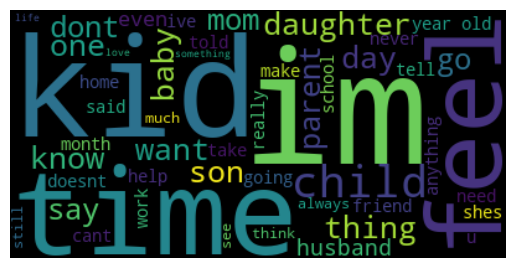

In [16]:
def show_word_cloud(num_of_words,word_list):
    text = ', '.join(word_list)
    # Create and generate a word cloud image:
    wordcloud = WordCloud(max_words=num_of_words).generate(text)

    # Display the generated image:
    fig, ax = plt.subplots()
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    plt.gcf().set_facecolor('none')
    plt.show()

show_word_cloud(50,mum_lst)

#### Show Ngrams of most used words

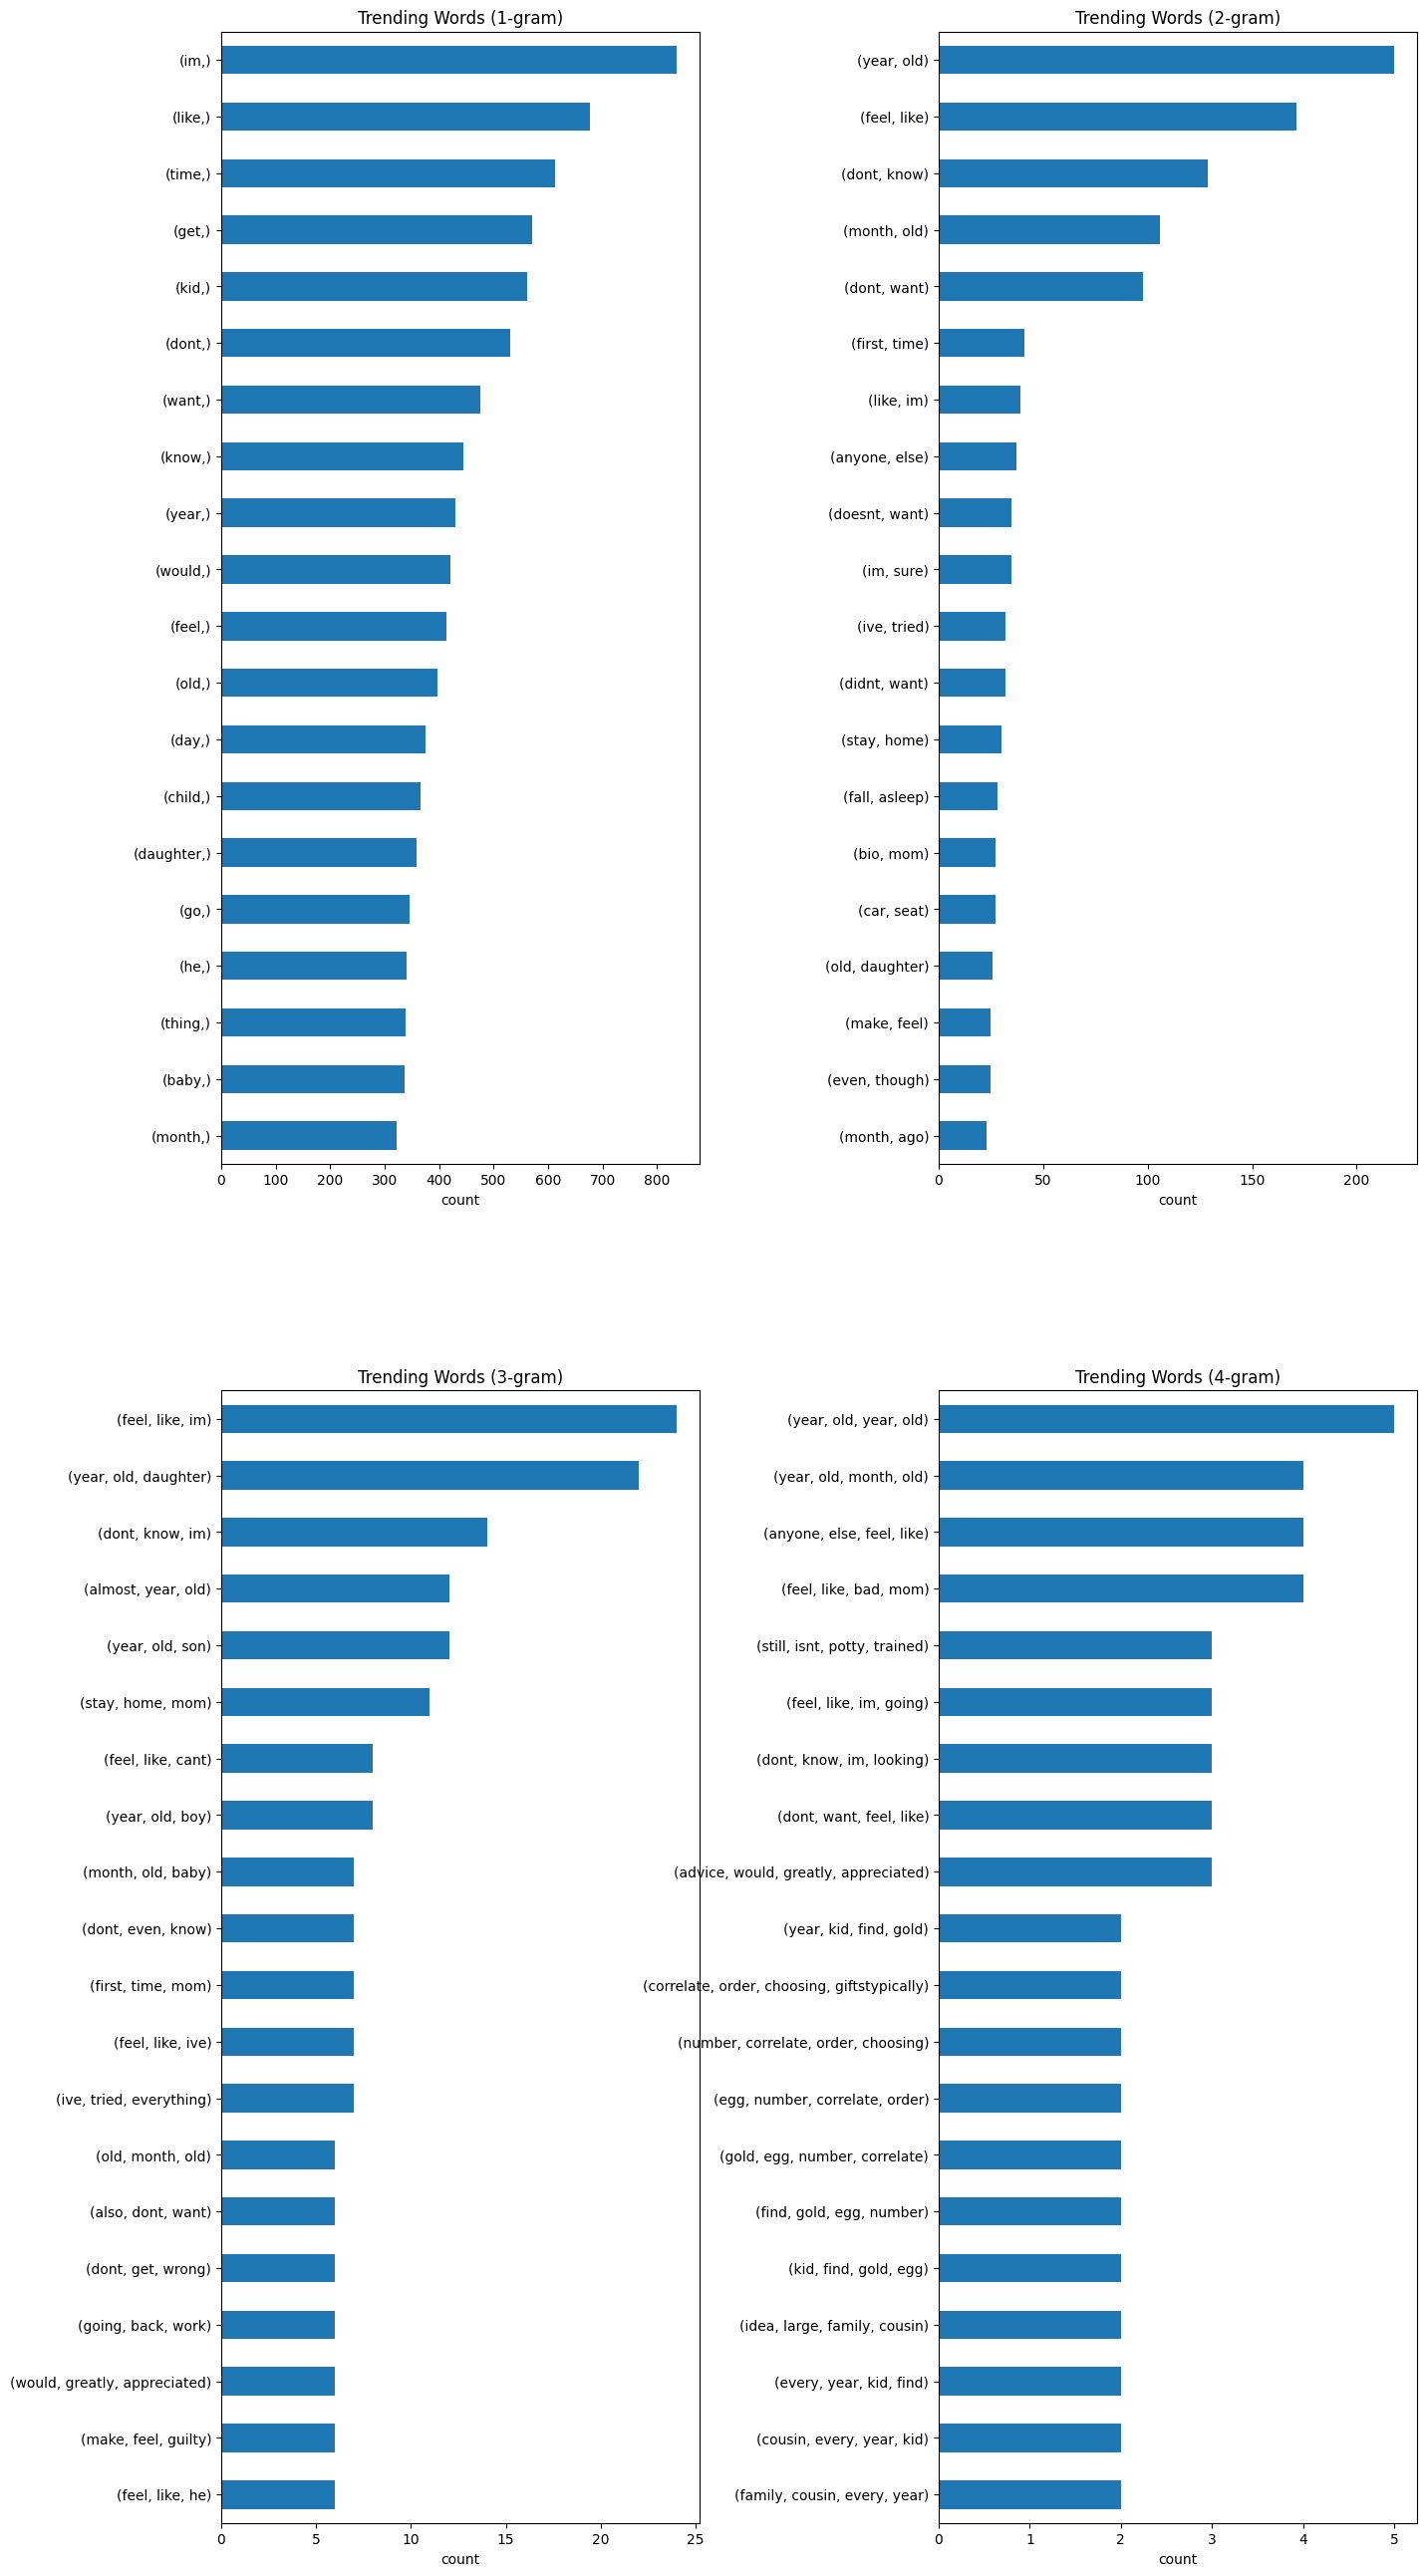

In [17]:
def show_ngram(text_list):
# plotting for N-gram
    fig, axes = plt.subplots(2, 2, figsize=(15,50)) 
    pd.Series(nltk.ngrams(text_list, 1)).value_counts().sort_values()[-20:].plot(kind='barh',title='Trending Words (1-gram)',ax=axes[0,0], xlabel='count')
    pd.Series(nltk.ngrams(text_list, 2)).value_counts().sort_values()[-20:].plot(kind='barh',title='Trending Words (2-gram)',ax=axes[0,1], xlabel='count')
    pd.Series(nltk.ngrams(text_list, 3)).value_counts().sort_values()[-20:].plot(kind='barh',title='Trending Words (3-gram)',ax=axes[1,0], xlabel='count')
    pd.Series(nltk.ngrams(text_list, 4)).value_counts().sort_values()[-20:].plot(kind='barh',title='Trending Words (4-gram)',ax=axes[1,1], xlabel='count')

    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.6, wspace=0.5, hspace=0.2)
    
    plt.gcf().set_facecolor('none')

show_ngram(mum_lst)